# Multi-agent network
- 출처 : https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/multi_agent/multi-agent-collaboration.ipynb
- 수정사항 : 한글화 및 일부 내용 수정


## 필수 패키지 설치

In [14]:
%%capture --no-stderr
%pip install -U langchain_community langchain_openai langchain_anthropic langchain_experimental matplotlib langgraph

##  API 키 설정
o ANTHROPIC_API_KEY : https://console.anthropic.com/settings/keys  
o TAVILY_API_KEY : https://app.tavily.com/home : API Keys

In [15]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("ANTHROPIC_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

Please provide your OPENAI_API_KEY··········


## 도구(Tool) 정의
에이전트가 사용할 도구를 정의(Define)

In [16]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## 그래프 만들기
이제 도구를 정의하고 일부 helper function을 만들었으므로 아래의   
개별 에이전트를 만들고 LangGraph를 사용하여 서로 대화하는 방법을 알려줍니다.

### 에이전트 노드 정의
먼저 각 에이전트에 대한 시스템 프롬프트를 만드는 유틸리티를 만듭니다.

In [17]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

"당신은 다른 어시스턴트들과 협업하는 유용한 AI 어시스턴트입니다."  
"제공된 도구를 사용하여 질문에 대한 답변을 진행하세요."   
"완전히 답변할 수 없어도 괜찮습니다. 다른 도구를 사용하는 다른 어시스턴트가 "  
" 중단한 부분부터 도와드릴 것입니다. 진행을 위해 할 수 있는 일을 실행하세요."   
"당신이나 다른 어시스턴트 중 누군가가 최종 답변이나 제공물을 가지고 있는 경우,"  
"팀이 중단해야 한다는 것을 알 수 있도록 답변 앞에 FINAL ANSWER를 붙여주세요."

In [22]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command


llm = ChatOpenAI(model="gpt-4-turbo")
# llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)


def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

### 그래프 정의
이제 모든 것을 모아 그래프를 정의합니다.

In [23]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

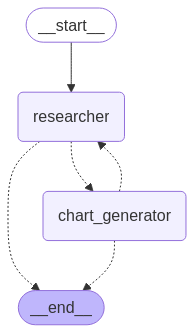

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 호출(Invoke)
그래프가 생성되었으니 호출할 수 있습니다!  
몇 가지 통계를 차트로 표시해 보겠습니다.

{'researcher': {'messages': [HumanMessage(content="First, get the KOREA's GDP over the past 10 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='38fc4672-dcfe-456a-80a3-44cadf91ed26'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_WN8cMVGoCHsRhp4GgNSLvnl7', 'function': {'arguments': '{"query": "South Korea GDP over the past 10 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 214, 'total_tokens': 256, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_bf9cb2c77f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d3fe7906-0dd0-4f49-9958-14240bf1e5bc-0', to

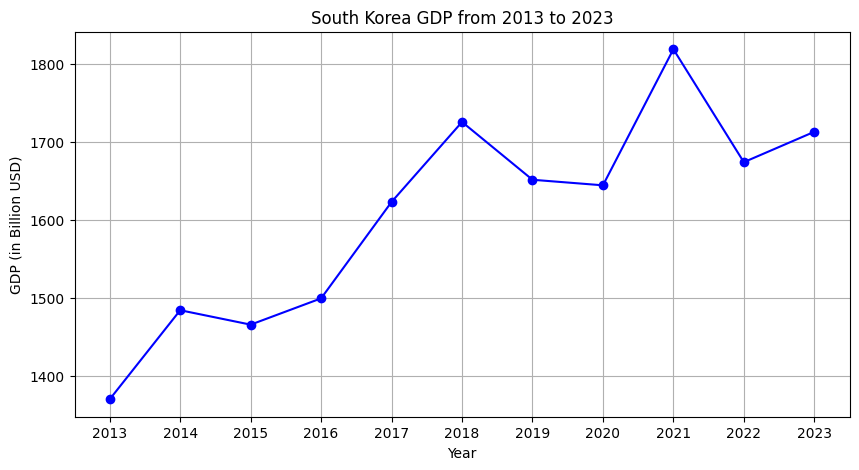

{'chart_generator': {'messages': [HumanMessage(content="First, get the KOREA's GDP over the past 10 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='38fc4672-dcfe-456a-80a3-44cadf91ed26'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_WN8cMVGoCHsRhp4GgNSLvnl7', 'function': {'arguments': '{"query": "South Korea GDP over the past 10 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 214, 'total_tokens': 256, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_bf9cb2c77f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d3fe7906-0dd0-4f49-9958-14240bf1e5bc-0

In [26]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the KOREA's GDP over the past 10 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")